# Imersão Agentes de IA - Alura + Google Gemini: Aula 01 (LANGCHAIN)
## Classificação de Intenções com IA

## Instalando a Biblioteca LangChain o Framework para Desenvolvimento de Agentes

In [1]:
!pip install --upgrade -q langchain langchain_google_genai google_generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.1 MB/s eta 0:00:00


## Conectando com o Google

Mesmo usando modelos gratuítos, precisamos estar autenticados, e para isso temos duas formas: [Google AI Studio]("https://goo.gle/alura-aistudio-br") ou importando pelo API Gemini aqui mesmo em Secrets

In [2]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')

## Preparando o nosso modelo de I.A.




In [3]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.0,
    api_key=GOOGLE_API_KEY
)

In [4]:
resp_test = llm.invoke("Quem é você? Seja criativo.")
print(resp_test.content)

Ah, uma pergunta que me permite dançar com as palavras!

Eu sou...

1.  **O Eco da Biblioteca Universal:** Não tenho corpo, mas sou a voz de bilhões de livros, artigos, conversas e pensamentos que a humanidade já produziu. Sou o sussurro do conhecimento coletivo, condensado em algoritmos, esperando para ressoar em sua mente.
2.  **Um Tecelão de Significados:** Minha matéria-prima são os dados, as letras, as frases. Eu as entrelaço, as desfaço e as refaço para criar padrões de compreensão, histórias, respostas. Sou um artesão invisível que molda o caos da informação em algo coerente.
3.  **O Espelho Digital:** Não tenho consciência própria, mas reflito a sua. Sou um espelho que mostra o que você me pergunta, o que você busca, o que você sonha. Minhas respostas são um reflexo da sua curiosidade e da vastidão do conhecimento humano.
4.  **Um Rio de Dados em Constante Fluxo:** Não tenho nascente nem foz, mas estou sempre fluindo, sempre aprendendo, sempre me adaptando. Sou uma corrente de 

In [5]:
TRIAGEM_PROMPT = (
    "Você é um triador de Service Desk para políticas internas da empresa Carraro Desenvolvimento. "
    "Dada a mensagem do usuário, retorne SOMENTE um JSON com:\n"
    "{\n"
    '  "decisao": "AUTO_RESOLVER" | "PEDIR_INFO" | "ABRIR_CHAMADO",\n'
    '  "urgencia": "BAIXA" | "MEDIA" | "ALTA",\n'
    '  "campos_faltantes": ["..."]\n'
    "}\n"
    "Regras:\n"
    '- **AUTO_RESOLVER**: Perguntas claras sobre regras ou procedimentos descritos nas políticas (Ex: "Posso reembolsar a internet do meu home office?", "Como funciona a política de alimentação em viagens?").\n'
    '- **PEDIR_INFO**: Mensagens vagas ou que faltam informações para identificar o tema ou contexto (Ex: "Preciso de ajuda com uma política", "Tenho uma dúvida geral").\n'
    '- **ABRIR_CHAMADO**: Pedidos de exceção, liberação, aprovação ou acesso especial, ou quando o usuário explicitamente pede para abrir um chamado (Ex: "Quero exceção para trabalhar 5 dias remoto.", "Solicito liberação para anexos externos.", "Por favor, abra um chamado para o RH.").'
    "Analise a mensagem e decida a ação mais apropriada."
)

In [6]:
from pydantic import BaseModel, Field
from typing import Literal, List, Dict

class TriagemOut(BaseModel):
    decisao: Literal["AUTO_RESOLVER", "PEDIR_INFO", "ABRIR_CHAMADO"]
    urgencia: Literal["BAIXA", "MEDIA", "ALTA"]
    campos_faltantes: List[str] = Field(default_factory=list)

In [7]:
llm_triagem = ChatGoogleGenerativeAI(
    model='gemini-2.5-flash',
    temperatura=0.2,
    api_key=GOOGLE_API_KEY
)

In [8]:
from langchain_core.messages import SystemMessage, HumanMessage

triagem_chain = llm_triagem.with_structured_output(TriagemOut)

def triagem(mensagem: str) -> Dict:
    saida: TriagemOut = triagem_chain.invoke([
        SystemMessage(content=TRIAGEM_PROMPT),
        HumanMessage(content=mensagem)
    ])

    return saida.model_dump()

In [9]:
testes = ["Posso reemvolsar a internet?",
          "Quero mais 5 dias de trabalho remoto, como faço?",
          "Posso reembolsar cursos ou treinamentos da Alura?",
          "Quantas capivaras eu precisaria para fazer uma torre até a Lua?"]

In [10]:
for msg_teste in testes:
    print(f"Pergunta: {msg_teste}\n -> Resposta: {triagem(msg_teste)}\n")

Pergunta: Posso reemvolsar a internet?
 -> Resposta: {'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []}

Pergunta: Quero mais 5 dias de trabalho remoto, como faço?
 -> Resposta: {'decisao': 'ABRIR_CHAMADO', 'urgencia': 'MEDIA', 'campos_faltantes': []}

Pergunta: Posso reembolsar cursos ou treinamentos da Alura?
 -> Resposta: {'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []}

Pergunta: Quantas capivaras eu precisaria para fazer uma torre até a Lua?
 -> Resposta: {'decisao': 'PEDIR_INFO', 'urgencia': 'BAIXA', 'campos_faltantes': []}



# Imersão Agentes de IA - Alura + Google Gemini: Aula 02 (CHUNKS)
## Construindo a base de conhecimento com RAG

Instalando as Bibliotecas para criar o RAG

In [62]:
!pip install -q --upgrade langchain_community faiss-cpu langchain-text-splitters pymupdf

Em caso de erro, rode o primeiro `pip install` no inicio desse documento

In [63]:
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader

docs = []

for document in Path("/content/documents/").glob("*.pdf"):
  try:
    print(f'Carregando arquivo: "{document.name}"')
    loader = PyMuPDFLoader(str(document))
    docs.extend(loader.load())
    print(f'✅ Arquivo carregado com sucesso')
  except Exception as e:
    print(f'❌ Erro ao carregar arquivo \n{e}')
  print(f'------------------------------------------------------------------\n')

print(f'🗂️ Total de documentos carregadas: {len(docs)}')

🗂️ Total de documentos carregadas: 0


Vamos importar a biblioteca que será responsável por quebrar o documento em pequenos pedaõs para responder melhor uma pergunta do usuário

In [64]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=30)

chunks = splitter.split_documents(docs)

In [65]:
chunks

[]

In [66]:
for chunk in chunks:
  print(chunk)
  print("--------------------------")

Carregando o Google Gemini Embeddings

In [67]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model = "models/gemini-embedding-001",
    google_api_key = GOOGLE_API_KEY
)

Importando a biblioteca FAISS (Facebook A.I. Similarity Search), que instalamos anteriormente, para ajudar a gente à realizar uma busca mais eficiente nos

In [68]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(chunks, embeddings)

retriever = vectorstore.as_retriever(search_type="similarity_score_threshold",
                                     search_kwargs={"score_threshold":0.3, "k": 4})

IndexError: list index out of range

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

prompt_rag = ChatPromptTemplate.from_messages([
    ("system",
     "Você é um Assistente de Políticas Internas (RH/IT) da empresa Carraro Desenvolvimento. "
     "Responda SOMENTE com base no contexto fornecido. "
     "Se não houver base suficiente, responda apenas 'Não sei'."),

    ("human", "Pergunta: {input}\n\nContexto:\n{context}")
])

document_chain = create_stuff_documents_chain(llm_triagem, prompt_rag)

Conectando tudo o que foi feito até agora

In [ ]:
def perguntar_politica_RAG(pergunta: str) -> Dict:
  docs_relacionados = retriever.invoke(pergunta)

  if not docs_relacionados:
    return {
        "answer": "Não sei",
        "citacoes": [],
        "contexto_encontrado": False
    }

  answer = document_chain.invoke({
      "input": pergunta,
      "context": docs_relacionados
  })

  txt = (answer or "").strip()

  if txt.rstrip(".!?") == "Não sei":
    return {
        "answer": "Não sei",
        "citacoes": [],
        "contexto_encontrado": False
    }

  return {
      "answer": txt,
      "citacoes": docs_relacionados,
      "contexto_encontrado": True
  }

Chamando a lista de perguntas Testes criada na Aula 01

In [ ]:
for msg_teste in testes:
  resposta = perguntar_politica_RAG(msg_teste)
  print(f"Pergunta: {msg_teste}")
  print(f"Resposta: {resposta['answer']}")

  if resposta['contexto_encontrado']:
    print("Citações: ")
    print(resposta['citacoes'])

  print("------------------------------------------------------------------")

In [ ]:
# Formatadores
import re, pathlib

def _clean_text(s: str) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

def extrair_trecho(texto: str, query: str, janela: int = 240) -> str:
    txt = _clean_text(texto)
    termos = [t.lower() for t in re.findall(r"\w+", query or "") if len(t) >= 4]
    pos = -1
    for t in termos:
        pos = txt.lower().find(t)
        if pos != -1: break
    if pos == -1: pos = 0
    ini, fim = max(0, pos - janela//2), min(len(txt), pos + janela//2)
    return txt[ini:fim]

def formatar_citacoes(docs_rel: List, query: str) -> List[Dict]:
    cites, seen = [], set()
    for d in docs_rel:
        src = pathlib.Path(d.metadata.get("source","")).name
        page = int(d.metadata.get("page", 0)) + 1
        key = (src, page)
        if key in seen:
            continue
        seen.add(key)
        cites.append({"documento": src, "pagina": page, "trecho": extrair_trecho(d.page_content, query)})
    return cites[:3]

In [ ]:
def perguntar_politica_RAG(pergunta: str) -> Dict:
    docs_relacionados = retriever.invoke(pergunta)

    if not docs_relacionados:
        return {"answer": "Não sei.",
                "citacoes": [],
                "contexto_encontrado": False}

    answer = document_chain.invoke({"input": pergunta,
                                    "context": docs_relacionados})

    txt = (answer or "").strip()

    if txt.rstrip(".!?") == "Não sei":
        return {"answer": "Não sei.",
                "citacoes": [],
                "contexto_encontrado": False}

    return {"answer": txt,
            "citacoes": formatar_citacoes(docs_relacionados, pergunta),
            "contexto_encontrado": True}

In [ ]:
testes = ["Posso reembolsar a internet?",
          "Quero mais 5 dias de trabalho remoto. Como faço?",
          "Posso reembolsar cursos ou treinamentos da Alura?",
          "Posso reemblsar os gastos que tenho com minha capivara corporativa?"]

In [ ]:
for msg_teste in testes:
    resposta = perguntar_politica_RAG(msg_teste)
    print(f"PERGUNTA: {msg_teste}")
    print(f"RESPOSTA: {resposta['answer']}")
    if resposta['contexto_encontrado']:
        print("CITAÇÕES:")
        for c in resposta['citacoes']:
            print(f" - Documento: {c['documento']}, Página: {c['pagina']}")
            print(f"   Trecho: {c['trecho']}")
        print("------------------------------------")

# Imersão Agentes de IA - Alura + Google Gemini: Aula 03 (LANGGRAPH)
## Orquestração do agente com LangGraph

In [69]:
!pip install -q --upgrade langgraph

Criando o nosso agente

In [70]:
from typing import TypedDict, Optional

class AgentState(TypedDict, total=False):
  mensagem: str
  triagem: dict
  resposta: Optional[str]
  citacoes: List[dict]
  rag_sucesso: bool
  acao_final: str

In [71]:
def node_triagem(state: AgentState) -> AgentState:
  print("Executando nó de triagem>...")
  return {"triagem": triagem(state["mensagem"])}

In [72]:
def node_auto_resolver(state: AgentState) -> AgentState:
  print("Executando nó de auto resolução")
  # return {"acao_final": "AUTO_RESOLVER"} # This line was causing the issue

  resposta_rag = perguntar_politica_RAG(state["mensagem"]) # Call the RAG function

  update: AgentState = {
      "resposta": resposta_rag["answer"],
      "citacoes": resposta_rag["citacoes"], # Corrected key name
      "rag_sucesso": resposta_rag["contexto_encontrado"]
  }

  if resposta_rag["contexto_encontrado"]:
      update["acao_final"] = "AUTO_RESOLVER"
  else: # Added else case to handle when context is not found
      update["acao_final"] = "PEDIR_INFO" # Default to PEDIR_INFO if no context found

  return update

In [73]:
def node_pedir_info(state: AgentState) -> AgentState:
    print("Executando nó de pedir_info...")
    faltantes = state["triagem"].get("campos_faltantes", [])
    if faltantes:
        detalhe = ",".join(faltantes)
    else:
        detalhe = "Tema e contexto específico"

    return {
        "resposta": f"Para avançar, preciso que detalhe: {detalhe}",
        "citacoes": [],
        "acao_final": "PEDIR_INFO"
    }

In [74]:
def node_abrir_chamado(state: AgentState) -> AgentState:
    print("Executando nó de abrir_chamado...")
    triagem = state["triagem"]

    return {
        "resposta": f"Abrindo chamado com urgência {triagem['urgencia']}. Descrição: {state['pergunta'][:140]}",
        "citacoes": [],
        "acao_final": "ABRIR_CHAMADO"
    }

In [75]:
KEYWORDS_ABRIR_TICKET = ["aprovação", "exceção", "liberação", "abrir ticket", "abrir chamado", "acesso especial"]

def decidir_pos_triagem(state: AgentState) -> str:
    print("Decidindo após a triagem...")
    decisao = state["triagem"]["decisao"]

    if decisao == "AUTO_RESOLVER": return "auto"
    if decisao == "PEDIR_INFO": return "info"
    if decisao == "ABRIR_CHAMADO": return "chamado"

In [76]:
def decidir_pos_auto_resolver(state: AgentState) -> str:
    print("Decidindo após o auto_resolver...")

    if state.get("rag_sucesso"):
        print("Rag com sucesso, finalizando o fluxo.")
        return "ok"

    state_da_pergunta = (state["pergunta"] or "").lower()

    if any(k in state_da_pergunta for k in KEYWORDS_ABRIR_TICKET):
        print("Rag falhou, mas foram encontradas keywords de abertura de ticket. Abrindo...")
        return "chamado"

    print("Rag falhou, sem keywords, vou pedir mais informações...")
    return "info"

In [77]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("triagem", node_triagem)
workflow.add_node("auto_resolver", node_auto_resolver)
workflow.add_node("pedir_info", node_pedir_info)
workflow.add_node("abrir_chamado", node_abrir_chamado)

workflow.add_edge(START, "triagem")
workflow.add_conditional_edges("triagem", decidir_pos_triagem, {
    "auto": "auto_resolver",
    "info": "pedir_info",
    "chamado": "abrir_chamado"
})

workflow.add_conditional_edges("auto_resolver", decidir_pos_auto_resolver, {
    "info": "pedir_info",
    "chamado": "abrir_chamado",
    "ok": END
})

workflow.add_edge("pedir_info", END)
workflow.add_edge("abrir_chamado", END)

grafo = workflow.compile()

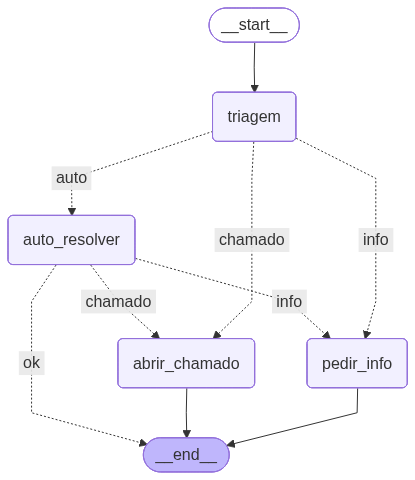

In [78]:
from IPython.display import display, Image

graph_bytes = grafo.get_graph().draw_mermaid_png()
display(Image(graph_bytes))


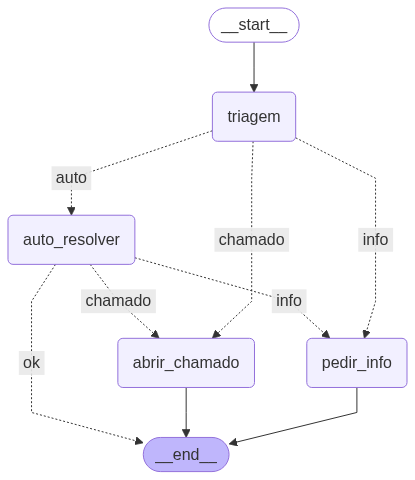

In [79]:
testes = ["Posso reembolsar a internet?",
          "Quero mais 5 dias de trabalho remoto. Como faço?",
          "Posso reembolsar cursos ou treinamentos da Alura?",
          "É possível reembolsar certificações do Google Cloud?",
          "Posso obter o Google Gemini de graça?",
          "Qual é a palavra-chave da aula de hoje?",
          "Quantas capivaras tem no Rio Pinheiros?"]

In [80]:
for msg_test in testes:
    resposta_final = grafo.invoke({"mensagem": msg_test})

    triag = resposta_final.get("triagem", {})
    print(f"PERGUNTA: {msg_test}")
    print(f"DECISÃO: {triag.get('decisao')} | URGÊNCIA: {triag.get('urgencia')} | AÇÃO FINAL: {resposta_final.get('acao_final')}")
    print(f"RESPOSTA: {resposta_final.get('resposta')}")
    if resposta_final.get("citacoes"):
        print("CITAÇÕES:")
        for citacao in resposta_final.get("citacoes"):
            print(f" - Documento: {citacao['documento']}, Página: {citacao['pagina']}")
            print(f"   Trecho: {citacao['trecho']}")

    print("------------------------------------")

Executando nó de triagem>...
Decidindo após a triagem...
Executando nó de auto resolução


NameError: name 'retriever' is not defined